In [100]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [120]:
vehiculo = 'DA02'

In [121]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

211

In [122]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [123]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [124]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

23

In [125]:
contenido_filtrado

['2025-09-11 08-44-22.tlog',
 '2025-09-12 14-07-43.tlog',
 '2025-09-18 16-50-36.tlog',
 '2025-10-16 16-03-04.tlog',
 '2025-10-16 19-50-48.tlog',
 '2025-10-16 20-49-16.tlog',
 '2025-10-16 21-07-02.tlog',
 '2025-10-16 21-31-50.tlog',
 '2025-10-16 22-05-27.tlog',
 '2025-10-17 19-38-53.tlog',
 '2025-10-17 20-17-35.tlog',
 '2025-10-17 21-52-37.tlog',
 '2025-10-17 22-16-11.tlog',
 '2025-10-17 22-59-42.tlog',
 '2025-10-18 00-07-04.tlog',
 '2025-10-18 00-56-25.tlog',
 '2025-10-18 02-03-10.tlog',
 '2025-10-18 02-31-14.tlog',
 '2025-10-18 03-39-23.tlog',
 '2025-10-18 04-08-59.tlog',
 '2025-10-18 04-28-30.tlog',
 '2025-10-18 05-07-15.tlog',
 '2025-10-18 08-00-31.tlog']

In [126]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [127]:
lineas, names = leer_logs(contenido_filtrado)
lineas

[<LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-63.264 -17.316, -63.264 -17.316, -63.264 -17.316, -63.264 -17....>,
 <LINESTRING (-63.296 -17.308, -63.296 -17.308, -63.296 -17.308, -63.296 -17....>,
 <LINESTRING (-63.297 -17.309, -63.297 -17.308, -63.297 -17.308, -63.297 -17....>,
 <LINESTRING (-63.314 -17.314, -63.314 -17.314, -63.314 -17.314, -63.314 -17....>,
 <LINESTRING (-63.316 -17.313, -63.316 -17.313, -63.316 -17.313, -63.316 -17....>,
 <LINESTRING (-63.319 -17.311, -63.319 -17.311, -63.319 -17.311, -63.319 -17....>,
 <LINESTRING (-63.319 -17.311, -63.319 -17.311, -63.319 -17.311, -63.319 -17....>,
 <LINESTRING (-63.165 -17.178, -63.165 -17.178, -63.165 -17.178, -63.165 -17....>,
 <LINESTRING (-63.208 -17.212, -63.208 -17.212, -63.208 -17.212, -63.208 -17....>,
 <LI

In [128]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-09-11 08-44-22.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2025-09-12 14-07-43.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
2,2025-09-18 16-50-36.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."


In [129]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [130]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [131]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [132]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-10-16 16-03-04.tlog,"LINESTRING (-63.26355 -17.31637, -63.26355 -17...",745,DA02
1,2025-10-16 19-50-48.tlog,"LINESTRING (-63.29644 -17.30803, -63.29644 -17...",855,DA02
2,2025-10-16 20-49-16.tlog,"LINESTRING (-63.29666 -17.30852, -63.29666 -17...",5194,DA02


<Axes: >

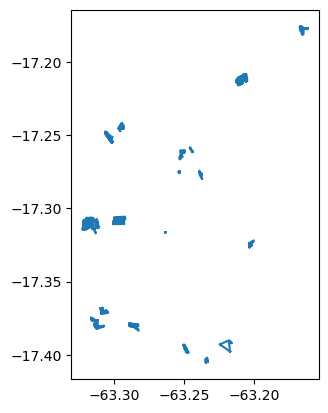

In [133]:
gdf_lines.plot()

In [134]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

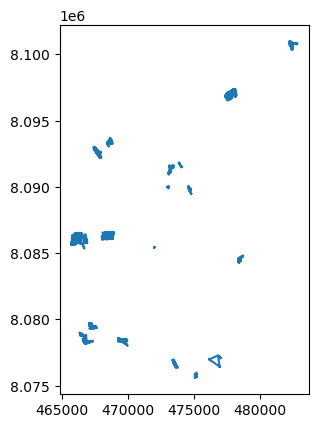

In [135]:
gdf_lines_utm.plot()

In [136]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [137]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2025-10-16 16-03-04.tlog,"LINESTRING (471994.488 8085427.051, 471994.488...",745,DA02,0
1,2025-10-16 19-50-48.tlog,"LINESTRING (468497.361 8086344.828, 468497.361...",855,DA02,0
2,2025-10-16 20-49-16.tlog,"LINESTRING (468475.011 8086290.651, 468474.134...",5194,DA02,0
3,2025-10-16 21-07-02.tlog,"LINESTRING (466599.929 8085728.143, 466599.929...",1743,DA02,0
4,2025-10-16 21-31-50.tlog,"LINESTRING (466441.622 8085755.564, 466439.786...",886,DA02,0
5,2025-10-16 21-31-50.tlog,"LINESTRING (466146.921 8086039.741, 466146.942...",90,DA02,0
6,2025-10-16 22-05-27.tlog,"LINESTRING (466147.144 8086040.195, 466147.144...",5416,DA02,0
7,2025-10-16 22-05-27.tlog,"LINESTRING (466147.852 8086042.220, 466147.863...",126,DA02,0
8,2025-10-17 19-38-53.tlog,"LINESTRING (466147.567 8086041.545, 466147.567...",2721,DA02,0
9,2025-10-17 20-17-35.tlog,"LINESTRING (482455.029 8100772.225, 482455.040...",2345,DA02,0


In [138]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)